# Prédiction des Émisison de CO²

In [52]:
import numpy as np
import pandas as pd
pd.options.display.max_columns = 1000
import matplotlib.pyplot as plt
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, classification_report, confusion_matrix
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import make_scorer

In [53]:
data = pd.read_csv('dataset_batiment.csv')
rmse_results = pd.DataFrame()

## Suppression des variables directement liés à la variable Emission de Gaz (cible directe) ainsi que les variables liées à la consommation énergétique (autre cible)

In [54]:
print('Avant : ', data.shape[1])
# Variable lié à l'autre cible
data = data.drop(labels=['SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'Electricity(kBtu)', 'Electricity(kWh)'], axis=1)
# Variable lié à la Target
data = data.drop(labels=['NaturalGas(kBtu)', 'NaturalGas(therms)', 'SteamUse(kBtu)', 'GHGEmissionsIntensity'], axis=1)
print('Après : ', data.shape[1])
data.head()

Avant :  39
Après :  27


Latitude  Longitude  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
0  47.61220 -122.33799                1.0              12             88434   
1  47.61317 -122.33393                1.0              11            103566   
2  47.61412 -122.33664                1.0              10             61320   
3  47.61390 -122.33283                1.0              11             83008   
4  47.54576 -122.26853                1.0               2             56228   

   ENERGYSTARScore  TotalGHGEmissions  age  PropertyGFAParkingRatio  \
0             60.0             249.98   89                     0.00   
1             61.0             295.86   20                    14.55   
2             56.0             286.43   90                     0.00   
3             27.0             176.14   90                     0.00   
4             95.0              38.53   55                     0.00   

   PrimaryPropertyType_Distribution Center  PrimaryPropertyType_Hospital  \
0                                        0                             0   
1                                        0                             0   
2                                        0                             0   
3                                        0                             0   
4                                        0                             0   

   PrimaryPropertyType_Hotel  PrimaryPropertyType_K-12 School  \
0                          1                                0   
1                          1                                0   
2                          1                                0   
3                          1                                0   
4                          0                                1   

   PrimaryPropertyType_Large Office  PrimaryPropertyType_Low-Rise Multifamily  \
0                                 0                                         0   
1                                 0                                         0   
2                                 0                                         0   
3                                 0                                         0   
4                                 0                                         0   

   PrimaryPropertyType_Medical Office  PrimaryPropertyType_Mixed Use Property  \
0                                   0                                       0   
1                                   0                                       0   
2                                   0                                       0   
3                                   0                                       0   
4                                   0                                       0   

   PrimaryPropertyType_Office  PrimaryPropertyType_Other  \
0                           0                          0   
1                           0                          0   
2                           0                          0   
3                           0                          0   
4                           0                          0   

   PrimaryPropertyType_Refrigerated Warehouse  \
0                                           0   
1                                           0   
2                                           0   
3                                           0   
4                                           0   

   PrimaryPropertyType_Residence Hall  PrimaryPropertyType_Retail Store  \
0                                   0                                 0   
1                                   0                                 0   
2                                   0                                 0   
3                                   0                                 0   
4                                   0                                 0   

   PrimaryPropertyType_Senior Care Community  \
0                                          0   
1                                          0   
2                           

In [55]:
data = data.rename(columns={'TotalGHGEmissions': 'Target'})
y = data['Target']
print(y.describe())

X = data.drop(columns="Target")
X

count    979.000000
mean      69.561696
std       71.299694
min       -0.800000
25%       17.950000
50%       42.450000
75%       94.635000
max      303.690000
Name: Target, dtype: float64


Latitude  Longitude  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
0    47.61220 -122.33799                1.0              12             88434   
1    47.61317 -122.33393                1.0              11            103566   
2    47.61412 -122.33664                1.0              10             61320   
3    47.61390 -122.33283                1.0              11             83008   
4    47.54576 -122.26853                1.0               2             56228   
..        ...        ...                ...             ...               ...   
974  47.53161 -122.29944                1.0               2             24990   
975  47.58831 -122.30650                1.0               3             45000   
976  47.63572 -122.37525                1.0               1             13661   
977  47.56440 -122.27813                1.0               1             15398   
978  47.56722 -122.31154                1.0               1             12294   

     ENERGYSTARScore  age  PropertyGFAParkingRatio  \
0               60.0   89                     0.00   
1               61.0   20                    14.55   
2               56.0   90                     0.00   
3               27.0   90                     0.00   
4               95.0   55                     0.00   
..               ...  ...                      ...   
974              9.0   87                     0.00   
975             77.0    1                     0.00   
976             75.0   64                     0.00   
977             93.0   56                     0.00   
978             46.0   26                     0.00   

     PrimaryPropertyType_Distribution Center  PrimaryPropertyType_Hospital  \
0                                          0                             0   
1                                          0                             0   
2                                          0                             0   
3                                          0                             0   
4                                          0                             0   
..                                       ...                           ...   
974                                        0                             0   
975                                        0                             0   
976                                        0                             0   
977                                        0                             0   
978                                        0                             0   

     PrimaryPropertyType_Hotel  PrimaryPropertyType_K-12 School  \
0                            1                                0   
1                            1                                0   
2                            1                                0   
3                            1                                0   
4                            0                                1   
..                         ...                              ...   
974                          0                                0   
975                          0                                1   
976                          0                                0   
977                          0                                0   
978                          0                                0   

     PrimaryPropertyType_Large Office  \
0                                   0   
1                                   0   
2                                   0   
3                                   0   
4                                   0   
..                                ...   
974                                 0   
975                                 0   
976                                 0   
977                                 0   
978                                 0   

     PrimaryPropertyType_Low-Rise Multifamily  \
0                                           0   
1                                           0   
2

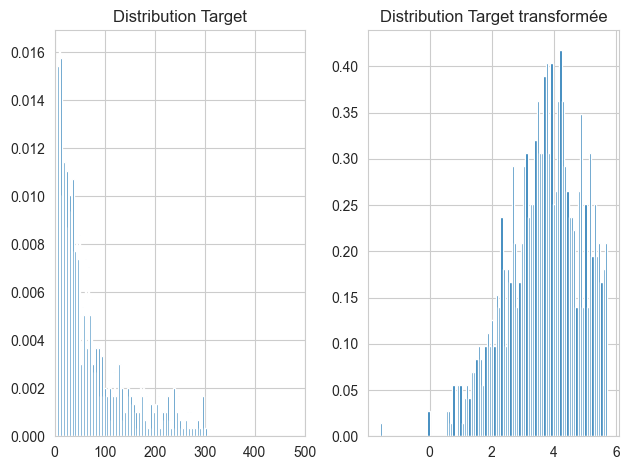

In [56]:
f, (ax0, ax1) = plt.subplots(1, 2)

ax0.hist(y, bins=100, density=True)
ax0.set_xlim([0, 500])
ax0.set_title("Distribution Target")

ax1.hist(np.log1p(y), bins=100, density=True)
ax1.set_title("Distribution Target transformée")

plt.tight_layout()

## Séparation du jeu de données

In [57]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Taille du jeu d'entrainement : ", X_train.shape)
print("Taille du jeu de test : ", X_test.shape)

Taille du jeu d'entrainement :  (783, 26)
Taille du jeu de test :  (196, 26)


## Scaling des données

In [58]:
from sklearn import preprocessing

std_scale = preprocessing.StandardScaler().fit(X_train)

X_train[X_train.columns] = std_scale.transform(X_train[X_train.columns])
X_test[X_test.columns] = std_scale.transform(X_test[X_test.columns])

## Transformation en Log de du jeu de données de train et test X

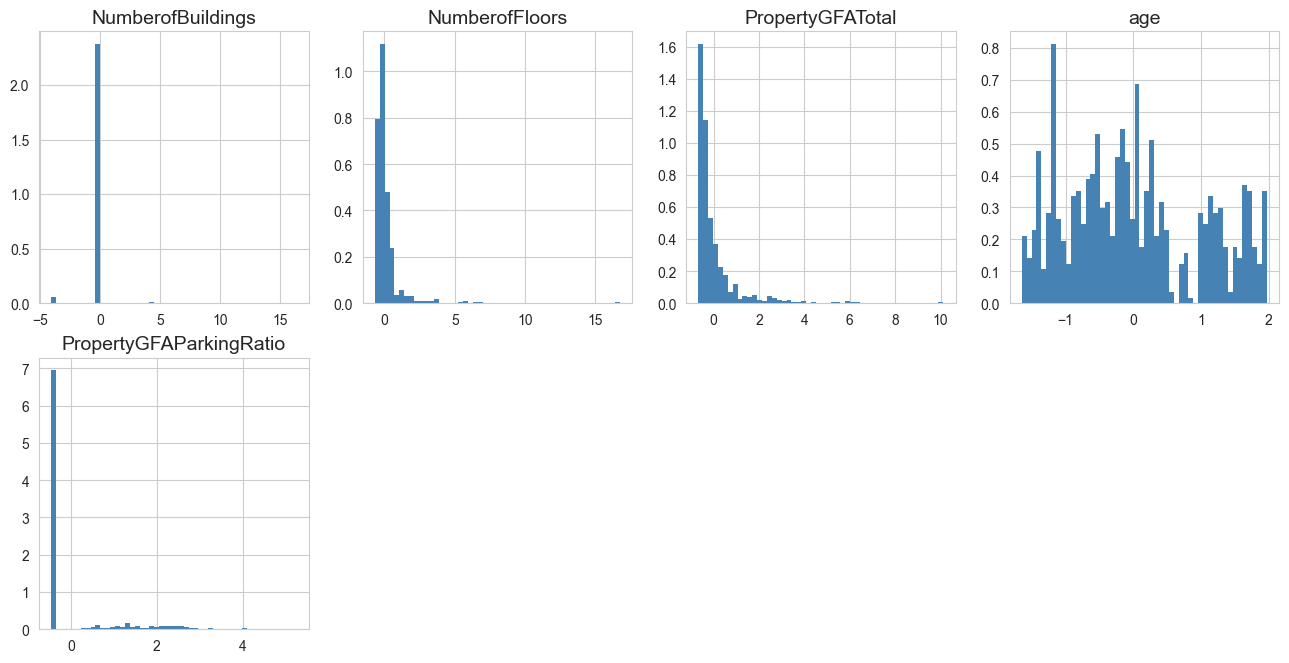

In [59]:
features = ['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'age', 'PropertyGFAParkingRatio']
fig = plt.figure(figsize=(16, 12))
for i, feature in enumerate(features):
    ax = fig.add_subplot(3,4, (i+1))
    h = ax.hist(X_train[feature], bins=50, color='steelblue', density=True, edgecolor='none')
    ax.set_title(feature, fontsize=14)

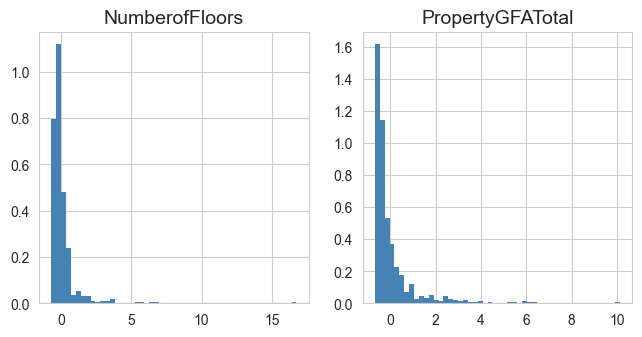

In [60]:
X_train_log = X_train.copy(deep=True)
X_test_log = X_test.copy(deep=True)
X_train_log['NumberofFloors'] = np.log1p(X_train['NumberofFloors'])
X_train_log['PropertyGFATotal'] = np.log1p(X_train['PropertyGFATotal'])

X_test_log['NumberofFloors'] = np.log1p(X_test['NumberofFloors'])
X_test_log['PropertyGFATotal'] = np.log1p(X_test['PropertyGFATotal'])

log_features = ['NumberofFloors', 'PropertyGFATotal']

fig = plt.figure(figsize=(16, 12))

for i, feature in enumerate(log_features):
    ax = fig.add_subplot(3,4, (i+1))
    h = ax.hist(X_train[feature], bins=50, color='steelblue', density=True, edgecolor='none')
    ax.set_title(feature, fontsize=14)

## Modélisation de la Baseline

In [61]:
estimator = DummyRegressor(strategy='median')
estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)
pd.Series(y_pred).value_counts()
train_score = estimator.score(X_train, y_train).round(4)
test_score = estimator.score(X_test, y_test).round(4)

print("r² sur les données d'entrainement : ", train_score)
print("r² sur les données de test : ", test_score)
print("RMSE sur les données de Test : ", mean_squared_error(y_true=y_test, y_pred=y_pred, squared=False))
rmse_results['Baseline'] = [mean_squared_error(y_true=y_test, y_pred=y_pred, squared=False)]

r² sur les données d'entrainement :  -0.1483
r² sur les données de test :  -0.1534
RMSE sur les données de Test :  72.9991662379001


## Knn Regressor

In [62]:
scorer = make_scorer(mean_squared_error, greater_is_better=False)
params = {
    'n_neighbors': [8,9,10],
    'weights': ['distance'],
    'metric': ['minkowski', 'euclidean', 'manhattan'],
}

knn_grid = GridSearchCV(KNeighborsRegressor(),
                    param_grid=params,
                    cv=10,
                    n_jobs=-1,
                    return_train_score=True,
                    verbose=1,
                    scoring=scorer)

knn_grid.fit(X_train, y_train)
print(knn_grid.best_params_)

knn_y_pred = knn_grid.predict(X_test)
knn_r2 = r2_score(y_true=y_test, y_pred=knn_y_pred)
knn_rmse = mean_squared_error(y_true=y_test, y_pred=knn_y_pred, squared=False)
print('KNN Regressor Algo : RMSE sur les données de Test', round(knn_rmse, 2))
rmse_results['KNN Regressor'] = [round(knn_rmse, 2)]

Fitting 10 folds for each of 9 candidates, totalling 90 fits
{'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'distance'}
KNN Regressor Algo : RMSE sur les données de Test 56.21


In [63]:
tranformed_knn_regressor_estimator = TransformedTargetRegressor(regressor=KNeighborsRegressor(metric=knn_grid.best_params_['metric'], n_neighbors=knn_grid.best_params_['n_neighbors'], weights=knn_grid.best_params_['weights']), func=np.log1p, inverse_func=np.expm1)
tranformed_knn_regressor_estimator.fit(X_train_log, y_train)
transformed_knn_y_pred = tranformed_knn_regressor_estimator.predict(X_test_log)

transformed_elastic_rmse = mean_squared_error(y_true=y_test, y_pred=transformed_knn_y_pred, squared=False)
print('Log KNN Algo : RMSE sur les données de Test', round(transformed_elastic_rmse, 2))
rmse_results['Log KNN'] = [round(transformed_elastic_rmse, 2)]

Log KNN Algo : RMSE sur les données de Test 59.96


## Test du régresseur linéaire

In [64]:
linear_estimator = LinearRegression()
linear_estimator.fit(X_train, y_train)
linear_y_pred = linear_estimator.predict(X_test)

linear_r2 = r2_score(y_true=y_test, y_pred=linear_y_pred)
linear_rmse = mean_squared_error(y_true=y_test, y_pred=linear_y_pred, squared=False)

print('Linear Regressor Algo : R² sur les données de Test', round(linear_r2, 2))
print('Linear Regressor Algo : RMSE sur les données de Test', round(linear_rmse, 2))

rmse_results['Linear Regressor'] = [round(linear_rmse, 2)]

Linear Regressor Algo : R² sur les données de Test 0.41
Linear Regressor Algo : RMSE sur les données de Test 52.3


## Test de ElasticNet avec ElasticNetCV

In [65]:
from sklearn.linear_model import ElasticNetCV

elastic_estimator = ElasticNetCV(cv=5, random_state=42)
elastic_estimator.fit(X_train, y_train)
elastic_y_pred = elastic_estimator.predict(X_test)
print('ElasticNet Alpha value trouvé : ', round(elastic_estimator.alpha_, 2))

elastic_rmse = mean_squared_error(y_true=y_test, y_pred=elastic_y_pred, squared=False)
print('ElasticNet Algo : RMSE sur les données de Test', round(elastic_rmse, 2))

rmse_results['ElasticNet'] = [round(elastic_rmse, 2)]

ElasticNet Alpha value trouvé :  0.11
ElasticNet Algo : RMSE sur les données de Test 52.63


In [66]:
tranformed_elastic_regressor_estimator = TransformedTargetRegressor(regressor=ElasticNetCV(cv=5, random_state=42), func=np.log1p, inverse_func=np.expm1)
tranformed_elastic_regressor_estimator.fit(X_train_log, y_train)
transformed_elastic_y_pred = tranformed_elastic_regressor_estimator.predict(X_test_log)

transformed_elastic_rmse = mean_squared_error(y_true=y_test, y_pred=transformed_elastic_y_pred, squared=False)
print('Log ElasticNet Algo : RMSE sur les données de Test', round(transformed_elastic_rmse, 2))
rmse_results['Log ElasticNet'] = [round(transformed_elastic_rmse, 2)]

Log ElasticNet Algo : RMSE sur les données de Test 55.23


## Test de Support Vector Regression

In [67]:
from sklearn.svm import SVR

params_svr = {'C': [0.1, 1, 50, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10],
              'epsilon': [0.1, 1, 10],
          }

grid_svr = GridSearchCV(SVR(),
                    param_grid=params_svr,
                    cv=5,
                    n_jobs=-1,
                    return_train_score=True,
                    verbose=1,
                    scoring=scorer)

grid_svr.fit(X_train, y_train)

print(grid_svr.best_params_)
print(grid_svr.best_estimator_)

svr_y_pred = grid_svr.predict(X_test)

svr_rmse = mean_squared_error(y_true=y_test, y_pred=svr_y_pred, squared=False)
print('SVM Algo : RMSE sur les données de Test', round(svr_rmse, 2))
rmse_results['SVR'] = [round(svr_rmse, 2)]

Fitting 5 folds for each of 60 candidates, totalling 300 fits
{'C': 100, 'epsilon': 10, 'gamma': 0.01}
SVR(C=100, epsilon=10, gamma=0.01)
SVM Algo : RMSE sur les données de Test 52.97


In [68]:
tranformed_svr_regressor_estimator = TransformedTargetRegressor(regressor=SVR(C=grid_svr.best_params_['C'], epsilon=grid_svr.best_params_['epsilon'], gamma=grid_svr.best_params_['gamma']), func=np.log1p, inverse_func=np.expm1)
tranformed_svr_regressor_estimator.fit(X_train_log, y_train)
transformed_svr_y_pred = tranformed_svr_regressor_estimator.predict(X_test_log)

transformed_svr_rmse = mean_squared_error(y_true=y_test, y_pred=transformed_svr_y_pred, squared=False)
print('Log SVR Algo : RMSE sur les données de Test', round(transformed_svr_rmse, 2))
rmse_results['Log SVR'] = [round(transformed_svr_rmse, 2)]

Log SVR Algo : RMSE sur les données de Test 91.9


## Multiceptron MLPRegressor

In [18]:
from sklearn.neural_network import MLPRegressor

mlp_reg = MLPRegressor(max_iter=1000)
mlp_reg.fit(X_train, y_train)
mlp_y_pred = mlp_reg.predict(X_test)
mlp_rmse = mean_squared_error(y_true=y_test, y_pred=mlp_y_pred)
print('MLP Regressor RMSE : ', round(mlp_rmse, 2))

MLP Regressor RMSE :  70363.66


D:\PycharmProjects\pythonProject\oc-projet-consommation-batiments\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


## Méthodes ensemblistes

### Random Forest

In [19]:
from sklearn.ensemble import RandomForestRegressor

param_forest = {'max_depth': [10, 20, 40, 60, 80, 100],
                'min_samples_leaf': [1, 2, 4],
                'min_samples_split': [2, 5, 10],
                'n_estimators': [100, 200, 500, 1000]
                }

grid_forest = GridSearchCV(RandomForestRegressor(),
                    param_grid=param_forest,
                    cv=3,
                    n_jobs=-1,
                    verbose=2,
                    scoring=scorer)

grid_forest.fit(X_train, y_train)

print('best param : ', grid_forest.best_params_)
print(grid_forest.best_estimator_)

y_pred_forest = grid_forest.predict(X_test)
forest_rmse = mean_squared_error(y_true=y_test, y_pred=y_pred_forest, squared=False)
print("Random Forest RMSE", forest_rmse)
rmse_results['Random Forest'] = [round(forest_rmse, 2)]

Fitting 3 folds for each of 216 candidates, totalling 648 fits
best param :  {'max_depth': 100, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
RandomForestRegressor(max_depth=100, n_estimators=200)
Random Forest RMSE 380.94118002495054


In [20]:
tranformed_forest_regressor_estimator = TransformedTargetRegressor(regressor=RandomForestRegressor(max_depth=grid_forest.best_params_['max_depth'], min_samples_leaf=grid_forest.best_params_['min_samples_leaf'], min_samples_split=grid_forest.best_params_['min_samples_split'], n_estimators=grid_forest.best_params_['n_estimators']), func=np.log1p, inverse_func=np.expm1)
tranformed_forest_regressor_estimator.fit(X_train_log, y_train)
transformed_forest_y_pred = tranformed_forest_regressor_estimator.predict(X_test_log)

transformed_forest_rmse = mean_squared_error(y_true=y_test, y_pred=transformed_forest_y_pred, squared=False)
print('Log Random Forest Algo : RMSE sur les données de Test', round(transformed_forest_rmse, 2))
rmse_results['Log Forest'] = [round(transformed_forest_rmse, 2)]

Log Random Forest Algo : RMSE sur les données de Test 183.93


## XG Boost

In [21]:
from xgboost import XGBRegressor


xgb_parameters = {
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [3, 4, 5],
    'seed': [42]
}
xgb_grid = GridSearchCV(XGBRegressor(n_jobs=-1),
                        param_grid=xgb_parameters,
                        cv=5,
                        verbose=1,
                        scoring=scorer)

xgb_grid.fit(X_train, y_train)
print(xgb_grid.best_params_)
print(xgb_grid.best_estimator_)
xgb_y_pred = xgb_grid.predict(X_test)
xgb_rmse = mean_squared_error(y_true=y_test, y_pred=xgb_y_pred, squared=False)
print("Random Forest RMSE", round(xgb_rmse, 2))
rmse_results['XGBoost'] = [round(xgb_rmse, 2)]

Fitting 5 folds for each of 405 candidates, totalling 2025 fits
{'colsample_bytree': 1.0, 'gamma': 0.5, 'max_depth': 5, 'min_child_weight': 5, 'seed': 42, 'subsample': 0.6}
XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.5, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=5,
             missing=nan, monotone_constraints='()', n_estimators=100,
             n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)
Random Forest RMSE 297.97


In [22]:
tranformed_xgboost_regressor_estimator = TransformedTargetRegressor(regressor=XGBRegressor(colsample_bytree= 1.0, gamma= 0.5, max_depth= 3, min_child_weight= 5, seed= 42, subsample=0.6), func=np.log1p, inverse_func=np.expm1)
tranformed_xgboost_regressor_estimator.fit(X_train_log, y_train)
transformed_xgboost_y_pred = tranformed_xgboost_regressor_estimator.predict(X_test_log)

transformed_xgboost_rmse = mean_squared_error(y_true=y_test, y_pred=transformed_xgboost_y_pred, squared=False)
print('Log XGBoost Algo : RMSE sur les données de Test', round(transformed_xgboost_rmse, 2))
rmse_results['Log XGBoost'] = [round(transformed_xgboost_rmse, 2)]

Log XGBoost Algo : RMSE sur les données de Test 209.39


## Comparaison des modèles

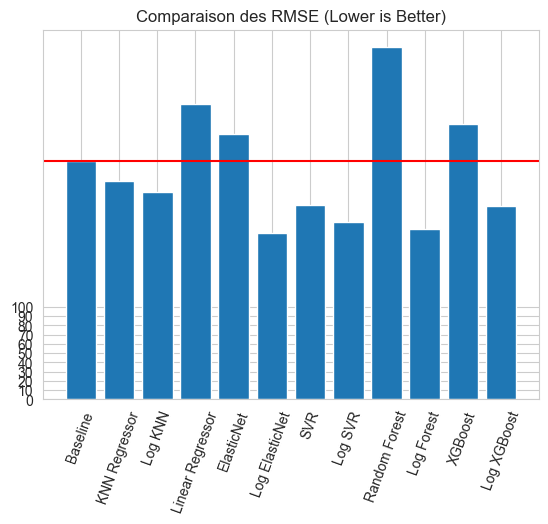

In [23]:
plt.bar(rmse_results.columns.to_list(), list(rmse_results.values[0]))
plt.xticks(rotation=70)
plt.yticks(ticks=[0,10, 20, 30 ,40 ,50 ,60, 70, 80, 90, 100])
plt.title('Comparaison des RMSE (Lower is Better)')
plt.axhline(y = rmse_results.loc[:, 'Baseline'][0], color = 'r', linestyle = '-')
plt.show()

# Feature Importance

## Feature Importance SKlearn

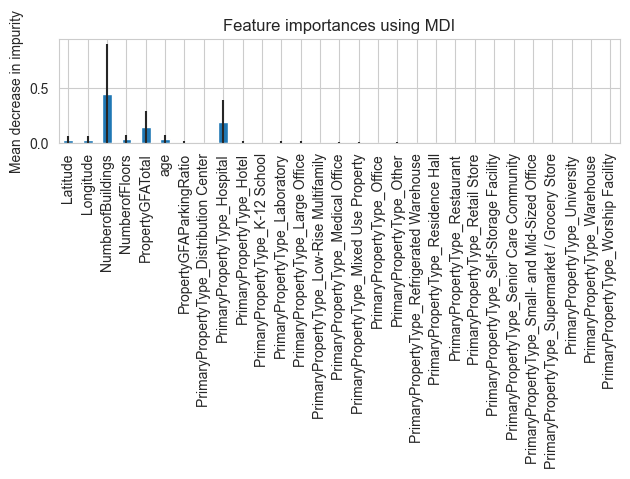

In [24]:
importances = grid_forest.best_estimator_.feature_importances_
std = np.std([tree.feature_importances_ for tree in grid_forest.best_estimator_.estimators_], axis=0)


forest_importances = pd.Series(importances, index=X.columns.to_list())
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=forest_importances.values, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## Feature Importance DecisionTree

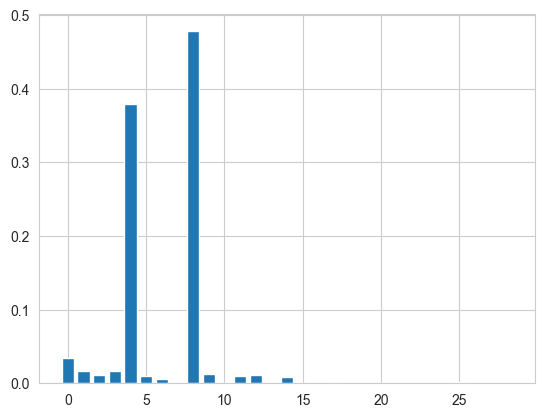

In [25]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor()
model.fit(X, y)
importance = model.feature_importances_
plt.bar([x for x in range(len(importance))], importance)
plt.show()

### SHAP (Shapley Additive Explanations)

In [ ]:
import shap
# Create object that can calculate shap values
explainer = shap.TreeExplainer(grid_forest.best_estimator_)
# Calculate Shap values
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values=shap_values, features=X_train, feature_names=X_train.columns.to_list(), plot_type="bar")

In [ ]:
shap.summary_plot(shap_values=shap_values, features=X_train, feature_names=X_train.columns.to_list())

In [ ]:
from shap import initjs
initjs()

i = 18
shap.force_plot(explainer.expected_value, shap_values[i], X_train.iloc[i, :], feature_names =X_train.columns.to_list())

 Rank ENERGYSTARScore : 5

In [ ]:
tranformed_elastic_regressor_estimator_no_energy_star = TransformedTargetRegressor(regressor=ElasticNetCV(cv=5, random_state=42), func=np.log1p, inverse_func=np.expm1)
tranformed_elastic_regressor_estimator_no_energy_star.fit(X_train_log.drop(labels='ENERGYSTARScore', axis='columns'), y_train)
transformed_elastic_y_pred_no_energy_star = tranformed_elastic_regressor_estimator_no_energy_star.predict(X_test_log.drop(labels='ENERGYSTARScore', axis='columns'))

transformed_elastic_rmse_no_energy_star = mean_squared_error(y_true=y_test, y_pred=transformed_elastic_y_pred_no_energy_star, squared=False)

print('RMSE ElasticNet sans ENERGYSTARScore : ', round(transformed_elastic_rmse_no_energy_star, 2))
print('RMSE ElasticNet avec ENERGYSTARScore : ', round(rmse_results['Log ElasticNet'][0], 2))

La RMSE est meilleure **avec** la feature ENERGYSTARScore, comme vu dans la feature importance, elle n'est pas la feature la plus importante mais elle améliore tout de même la précision du modèle.